In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.utils.class_weight import compute_class_weight

import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
import os

import time

/home/agavrilko/miniconda3/envs/torchenv/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Configuration

In [2]:
config = {'device':'cpu',#'cuda' if torch.cuda.is_available() else 'cpu',
          'batch_size':16,
          'num_recors_in_input':10,
          'step':5,
          'random_seed':42,
          'num_workers':os.cpu_count()}

## Dataloader

In [3]:
class CustomDataset(Dataset):
    def __init__(self, path: str, num_recors_in_input: int, step: int) -> None:
        super(CustomDataset, self).__init__()
        self.labels = ['boxing', 'jogging', 'running', 'walking', 'handclapping', 'handwaving']
        self.dataframe = pd.read_csv(path, index_col=0).reset_index()
        self.num_records_in_input = num_recors_in_input
        self.step = step
        self.indices_to_input = []
        self.classes = []

        self.extract_input_indices()
        
    def extract_input_indices(self):
        grouped_df = self.dataframe.groupby('src_video').agg({'Nose_X':'count', 'action':'first', 'index':'min'}).rename(columns={'Nose_X':'n_frames'})
        
        for record in grouped_df.iterrows():
            n_frames, action, index = record[1]
            if n_frames < self.num_records_in_input:
                continue
            
            curr_index = index
            while (curr_index + self.num_records_in_input) < (index + n_frames):
                self.indices_to_input.append(curr_index)
                self.classes.append(self.labels.index(action))
                curr_index += self.step
                
    def __len__(self):
        return len(self.indices_to_input)
    
    def __getitem__(self, index):
        internal_index = self.indices_to_input[index]
        label = self.classes[index]
        X = self.dataframe.iloc[internal_index:internal_index+self.num_records_in_input, :].drop(['index','action', 'src_video'], axis=1).to_numpy(dtype=np.float32)

        X = np.abs(X - X[0])
        
        return X * 100, label

In [4]:
train_dataset = CustomDataset('../data/train/train_data.csv', config['num_recors_in_input'], config['step'])
val_dataset = CustomDataset('../data/val/val_data.csv', config['num_recors_in_input'], config['step'])
test_dataset = CustomDataset('../data/test/test_data.csv', config['num_recors_in_input'], config['step'])
"""
scaler = MinMaxScaler()
train_dataset.dataframe.iloc[:, 1:-2] = scaler.fit_transform(train_dataset.dataframe.iloc[:, 1:-2])
val_dataset.dataframe.iloc[:, 1:-2] = scaler.transform(val_dataset.dataframe.iloc[:, 1:-2])
test_dataset.dataframe.iloc[:, 1:-2] = scaler.transform(test_dataset.dataframe.iloc[:, 1:-2])"""

"""encoder = OneHotEncoder(categories='auto')
train_dataset.classes = encoder.fit_transform(np.array(train_dataset.classes).reshape(-1, 1)).toarray()
val_dataset.classes = encoder.transform(np.array(val_dataset.classes).reshape(-1, 1)).toarray()
test_dataset.classes = encoder.transform(np.array(test_dataset.classes).reshape(-1, 1)).toarray()
"""
train_dataloader = DataLoader(train_dataset, config['batch_size'], shuffle=True, num_workers=config['num_workers'])#, pin_memory=True, pin_memory_device=config['device'])
val_dataloader = DataLoader(val_dataset, config['batch_size'], shuffle=False, num_workers=config['num_workers'])#, pin_memory=True, pin_memory_device=config['device'])
test_dataloader = DataLoader(test_dataset, config['batch_size'], shuffle=False, num_workers=config['num_workers'])#, pin_memory=True, pin_memory_device=config['device'])

In [5]:
start_time = time.time()
for X, y in train_dataloader:
    pass
print(f'Time to process train_dataset: {round(time.time() - start_time, 4)}')

Time to process train_dataset: 1.4253


## Model

In [6]:
class LSTMModel(nn.Module):
    def __init__(self, num_classes, input_size, num_layers, seq_length):
        super(LSTMModel, self).__init__()
        self.num_classes = num_classes #number of classes
        self.num_layers = num_layers #number of layers
        self.input_size = input_size #input size
        self.lstm_1_size = 16 * 1
        self.lstm_2_size = 32 * 1
        self.lstm_3_size = 16 * 1
        self.seq_length = seq_length #sequence length

        self.lstm_1 = nn.LSTM(input_size=input_size, hidden_size=self.lstm_1_size,
                          num_layers=num_layers, batch_first=True)
        self.lstm_2 = nn.LSTM(input_size=self.lstm_1_size, hidden_size=self.lstm_2_size,
                          num_layers=num_layers, batch_first=True)
        self.lstm_3 = nn.LSTM(input_size=self.lstm_2_size, hidden_size=self.lstm_3_size,
                          num_layers=num_layers, batch_first=True)
        
        self.fc_1 =  nn.Sequential(nn.Linear(self.lstm_3_size, 128))
        self.fc_2 =  nn.Sequential(nn.Linear(128, 32))
        self.classifier =  nn.Sequential(nn.Linear(32, self.num_classes))
        
    
    def forward(self,x):
        h_1 = torch.zeros(self.num_layers, x.size(0), self.lstm_1_size)
        c_1 = torch.zeros(self.num_layers, x.size(0), self.lstm_1_size)
        
        h_2 = torch.zeros(self.num_layers, x.size(0), self.lstm_2_size)
        c_2 = torch.zeros(self.num_layers, x.size(0), self.lstm_2_size)
        
        h_3 = torch.zeros(self.num_layers, x.size(0), self.lstm_3_size)
        c_3 = torch.zeros(self.num_layers, x.size(0), self.lstm_3_size)
        
        # Propagate input through LSTM
        output, (h_1, c_1) = self.lstm_1(x, (h_1, c_1))
        
        output, (h_2, c_2) = self.lstm_2(output, (h_2, c_2))
        
        output, (h_3, c_3) = self.lstm_3(output, (h_3, c_3))
        
        hn = h_3.view(-1, self.lstm_3_size)
        out = self.fc_1(hn)
        out = self.fc_2(out)
        out = self.classifier(out)
        
        return out

## Class weights

In [7]:
class_weights = compute_class_weight('balanced', classes = np.unique(train_dataset.classes), y = train_dataset.classes)
class_weights = torch.from_numpy(class_weights).type(torch.float32).to(config['device'])
class_weights

tensor([0.6892, 2.4085, 4.6655, 1.1871, 0.7496, 0.5737])

## Train pipeline

In [8]:
torch.cuda.manual_seed(42)
torch.manual_seed(42)

model = LSTMModel(6, 30, 1, 15)
loss_fn = nn.CrossEntropyLoss(class_weights, reduction='mean')
optimizer = torch.optim.RMSprop(model.parameters(), lr=1e-4, weight_decay=1e-5, momentum=0.1)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.9)


for epoch in tqdm(range(1, 100 + 1)):
    model.train()
    
    train_loss, train_acc = 0, 0
    
    for X, y in train_dataloader:
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        
        y_class_pred = torch.argmax(torch.softmax(y_pred, axis=1), axis=1)
        train_acc += (y_class_pred == y).sum().item()
        
    train_loss /= len(train_dataloader)
    train_acc /= len(train_dataloader.dataset)
    
    scheduler.step()
        
    val_loss, val_acc = 0, 0    
    model.eval()
    
    with torch.inference_mode():
        for X, y in val_dataloader:
            y_pred = model(X)
            loss = loss_fn(y_pred, y)
            
            val_loss += loss.item()
            
            y_class_pred = torch.argmax(torch.softmax(y_pred, axis=1), axis=1)
            val_acc += (y_class_pred == y).sum().item()
        
        
    val_loss /= len(val_dataloader)
    val_acc /= len(val_dataloader.dataset)
    
    if epoch%2 == 0:
        print(f'Loss: {train_loss} | Acc: {train_acc} | Val loss: {val_loss} | Val acc: {val_acc}')
    
    

  2%|▏         | 2/100 [00:12<10:08,  6.21s/it]

Loss: 1.06110402264918 | Acc: 0.5790657007244566 | Val loss: 0.822691277331776 | Val acc: 0.5646401118099231


  4%|▍         | 4/100 [00:24<09:33,  5.97s/it]

Loss: 0.8532291632961941 | Acc: 0.6360229827629278 | Val loss: 0.6699271900786294 | Val acc: 0.7463312368972747


  6%|▌         | 6/100 [00:36<09:43,  6.21s/it]

Loss: 0.8178147385082397 | Acc: 0.733949537846615 | Val loss: 0.586781966386156 | Val acc: 0.806429070580014


  8%|▊         | 8/100 [00:47<08:44,  5.70s/it]

Loss: 0.727824339561491 | Acc: 0.7659255558331252 | Val loss: 0.45747784790065554 | Val acc: 0.8581411600279525


 10%|█         | 10/100 [00:58<08:18,  5.54s/it]

Loss: 0.6860087035424206 | Acc: 0.8021483887084686 | Val loss: 0.39695678842771387 | Val acc: 0.8777078965758212


 12%|█▏        | 12/100 [01:11<08:54,  6.07s/it]

Loss: 0.6520231921537464 | Acc: 0.8248813389957532 | Val loss: 0.39633129631272623 | Val acc: 0.8078266946191475


 14%|█▍        | 14/100 [01:21<08:07,  5.67s/it]

Loss: 0.6300338424178233 | Acc: 0.8163877092180865 | Val loss: 0.3692999638798129 | Val acc: 0.883298392732355


 16%|█▌        | 16/100 [01:33<08:04,  5.76s/it]

Loss: 0.6188112990670945 | Acc: 0.8216337746689982 | Val loss: 0.3610101172415954 | Val acc: 0.8777078965758212


 18%|█▊        | 18/100 [01:44<07:45,  5.68s/it]

Loss: 0.6016787062603164 | Acc: 0.8226330252310767 | Val loss: 0.3458623217910321 | Val acc: 0.8805031446540881


 20%|██        | 20/100 [01:55<07:31,  5.65s/it]

Loss: 0.5894100556439493 | Acc: 0.8366225331001749 | Val loss: 0.346420609315909 | Val acc: 0.8218029350104822


 22%|██▏       | 22/100 [02:06<07:16,  5.59s/it]

Loss: 0.5815143948977449 | Acc: 0.8481139145640769 | Val loss: 0.34419093747079993 | Val acc: 0.8392732354996506


 24%|██▍       | 24/100 [02:17<07:06,  5.61s/it]

Loss: 0.5683250713841136 | Acc: 0.8341244066949788 | Val loss: 0.3193727841781866 | Val acc: 0.883298392732355


 26%|██▌       | 26/100 [02:29<06:51,  5.57s/it]

Loss: 0.5480696189094825 | Acc: 0.8456157881588808 | Val loss: 0.31760124655362837 | Val acc: 0.8874912648497554


 28%|██▊       | 28/100 [02:39<06:22,  5.32s/it]

Loss: 0.5383381973284175 | Acc: 0.8518611041718711 | Val loss: 0.30075347961521604 | Val acc: 0.8867924528301887


 30%|███       | 30/100 [02:48<05:55,  5.07s/it]

Loss: 0.5175897252868371 | Acc: 0.8593554833874594 | Val loss: 0.2937426924252779 | Val acc: 0.896575821104123


 32%|███▏      | 32/100 [02:58<05:38,  4.98s/it]

Loss: 0.49733465141152955 | Acc: 0.8690981763677242 | Val loss: 0.29025399441856686 | Val acc: 0.8860936408106219


 34%|███▍      | 34/100 [03:08<05:24,  4.91s/it]

Loss: 0.4801553264557128 | Acc: 0.8760929303022733 | Val loss: 0.28100525560439565 | Val acc: 0.8951781970649895


 36%|███▌      | 36/100 [03:18<05:13,  4.90s/it]

Loss: 0.46331812140060613 | Acc: 0.8790906819885086 | Val loss: 0.26114449309081667 | Val acc: 0.9014675052410901


 38%|███▊      | 38/100 [03:27<05:02,  4.88s/it]

Loss: 0.4442367910581875 | Acc: 0.8830876842368224 | Val loss: 0.2474366638654222 | Val acc: 0.9091544374563243


 40%|████      | 40/100 [03:37<04:52,  4.87s/it]

Loss: 0.4370824271048683 | Acc: 0.8930801898576068 | Val loss: 0.25085664169940475 | Val acc: 0.9119496855345912


 42%|████▏     | 42/100 [03:47<04:42,  4.86s/it]

Loss: 0.4285923824051907 | Acc: 0.8925805645765675 | Val loss: 0.2420161940632776 | Val acc: 0.9084556254367575


 44%|████▍     | 44/100 [03:57<04:32,  4.86s/it]

Loss: 0.4163718957350074 | Acc: 0.8938296277791656 | Val loss: 0.2403902469002383 | Val acc: 0.909853249475891


 46%|████▌     | 46/100 [04:07<04:25,  4.91s/it]

Loss: 0.4048851665315326 | Acc: 0.8988258805895578 | Val loss: 0.2329502585981067 | Val acc: 0.9147449336128581


 48%|████▊     | 48/100 [04:16<04:15,  4.92s/it]

Loss: 0.3983213505243875 | Acc: 0.9033225081189108 | Val loss: 0.23508916366198618 | Val acc: 0.9182389937106918


 50%|█████     | 50/100 [04:26<04:03,  4.87s/it]

Loss: 0.39392252381430914 | Acc: 0.9053210092430677 | Val loss: 0.2399786583510124 | Val acc: 0.907058001397624


 52%|█████▏    | 52/100 [04:36<03:55,  4.90s/it]

Loss: 0.38027980391203287 | Acc: 0.9093180114913815 | Val loss: 0.22585245101040022 | Val acc: 0.9203354297693921


 54%|█████▍    | 54/100 [04:46<03:45,  4.90s/it]

Loss: 0.3763734516186781 | Acc: 0.9105670746939795 | Val loss: 0.23237303975232257 | Val acc: 0.9161425576519916


 56%|█████▌    | 56/100 [04:55<03:34,  4.88s/it]

Loss: 0.3616425208738111 | Acc: 0.9150637022233326 | Val loss: 0.21874341046237128 | Val acc: 0.9217330538085255


 58%|█████▊    | 58/100 [05:05<03:24,  4.87s/it]

Loss: 0.3623001408796624 | Acc: 0.9168123907069697 | Val loss: 0.2214048623278763 | Val acc: 0.9245283018867925


 60%|██████    | 60/100 [05:15<03:14,  4.86s/it]

Loss: 0.35646271847366573 | Acc: 0.9165625780664501 | Val loss: 0.23081638551601727 | Val acc: 0.9203354297693921


 62%|██████▏   | 62/100 [05:24<03:04,  4.85s/it]

Loss: 0.34700641103007224 | Acc: 0.9225580814389208 | Val loss: 0.22476767959871924 | Val acc: 0.9203354297693921


 64%|██████▍   | 64/100 [05:34<02:54,  4.84s/it]

Loss: 0.3351883615637977 | Acc: 0.9210592055958031 | Val loss: 0.217326354047691 | Val acc: 0.9294199860237596


 66%|██████▌   | 66/100 [05:44<02:46,  4.89s/it]

Loss: 0.3428659350555613 | Acc: 0.9208093929552835 | Val loss: 0.219576387363486 | Val acc: 0.9280223619846262


 68%|██████▊   | 68/100 [05:54<02:36,  4.88s/it]

Loss: 0.3352503053254014 | Acc: 0.9235573320009992 | Val loss: 0.21917441025984266 | Val acc: 0.9168413696715584


 70%|███████   | 70/100 [06:04<02:27,  4.92s/it]

Loss: 0.3285299330964625 | Acc: 0.9270547089682738 | Val loss: 0.21363596878670957 | Val acc: 0.9308176100628931


 72%|███████▏  | 72/100 [06:13<02:16,  4.89s/it]

Loss: 0.3250582129342029 | Acc: 0.9278041468898326 | Val loss: 0.22262650425351846 | Val acc: 0.9224318658280922


 74%|███████▍  | 74/100 [06:23<02:08,  4.95s/it]

Loss: 0.32020430607847367 | Acc: 0.9255558331251561 | Val loss: 0.21760539609935625 | Val acc: 0.93361285814116


 76%|███████▌  | 76/100 [06:33<01:58,  4.94s/it]

Loss: 0.3157750713802221 | Acc: 0.9270547089682738 | Val loss: 0.22240724823026944 | Val acc: 0.9280223619846262


 78%|███████▊  | 78/100 [06:43<01:48,  4.92s/it]

Loss: 0.31475704152181566 | Acc: 0.9270547089682738 | Val loss: 0.21999647825691176 | Val acc: 0.9245283018867925


 80%|████████  | 80/100 [06:53<01:37,  4.87s/it]

Loss: 0.3118869665865434 | Acc: 0.9300524606545091 | Val loss: 0.2250284394745702 | Val acc: 0.9238294898672257


 82%|████████▏ | 82/100 [07:02<01:27,  4.89s/it]

Loss: 0.3042824877077246 | Acc: 0.9298026480139895 | Val loss: 0.22688088665551429 | Val acc: 0.9245283018867925


 84%|████████▍ | 84/100 [07:12<01:17,  4.85s/it]

Loss: 0.30730987575454305 | Acc: 0.9303022732950287 | Val loss: 0.2120962320366137 | Val acc: 0.9301187980433263


 86%|████████▌ | 86/100 [07:22<01:08,  4.89s/it]

Loss: 0.29965626594955586 | Acc: 0.9298026480139895 | Val loss: 0.21453516768249553 | Val acc: 0.9308176100628931


 88%|████████▊ | 88/100 [07:32<00:58,  4.90s/it]

Loss: 0.2947209178956144 | Acc: 0.9337996502623033 | Val loss: 0.2543277893758689 | Val acc: 0.9175401816911251


 90%|█████████ | 90/100 [07:42<00:48,  4.89s/it]

Loss: 0.294996136992398 | Acc: 0.9330502123407445 | Val loss: 0.22171415996466143 | Val acc: 0.9259259259259259


 92%|█████████▏| 92/100 [07:51<00:38,  4.84s/it]

Loss: 0.29098213462815786 | Acc: 0.9350487134649014 | Val loss: 0.21979043717405553 | Val acc: 0.9315164220824598


 94%|█████████▍| 94/100 [08:01<00:28,  4.82s/it]

Loss: 0.2830968734583784 | Acc: 0.9323007744191856 | Val loss: 0.21612053050670915 | Val acc: 0.9287211740041929


 96%|█████████▌| 96/100 [08:11<00:19,  4.89s/it]

Loss: 0.27941608318754757 | Acc: 0.9347989008243817 | Val loss: 0.21543416315382477 | Val acc: 0.9294199860237596


 98%|█████████▊| 98/100 [08:20<00:09,  4.87s/it]

Loss: 0.28410064016906655 | Acc: 0.936547589308019 | Val loss: 0.22020054810620623 | Val acc: 0.9273235499650594


100%|██████████| 100/100 [08:30<00:00,  5.11s/it]

Loss: 0.2829579219288857 | Acc: 0.9380464651511367 | Val loss: 0.21448674039598295 | Val acc: 0.9322152341020266


## Evaluation

In [9]:
test_loss, test_acc = 0, 0    
model.eval()

y_pred_concatenated = torch.IntTensor().to(config['device'])
y_concatenated = torch.IntTensor().to(config['device'])

with torch.inference_mode():
    for X, y in test_dataloader:
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        
        test_loss += loss.item()
        
        y_class_pred = torch.argmax(torch.softmax(y_pred, axis=1), axis=1)
        y_pred_concatenated = torch.cat([y_pred_concatenated, y_class_pred])
        y_concatenated = torch.cat([y_concatenated, y])
        test_acc += (y_class_pred == y).sum().item()
    
test_loss /= len(test_dataloader)
test_acc /= len(test_dataloader.dataset)

In [10]:
test_loss, test_acc

(0.5492822503657315, 0.876499647141849)

In [11]:
y_concatenated

tensor([0, 0, 0,  ..., 3, 3, 3])

<AxesSubplot:>

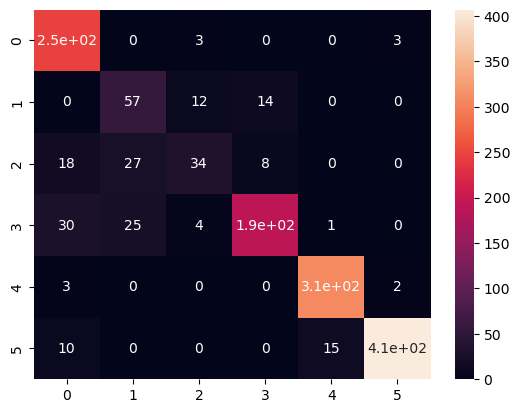

In [12]:
from sklearn.metrics import confusion_matrix, classification_report
confmat = confusion_matrix(y_pred_concatenated.cpu().numpy(), y_concatenated.cpu().numpy())
sns.heatmap(confmat, annot=True)

In [13]:
print(classification_report(y_pred_concatenated.cpu().numpy(), y_concatenated.cpu().numpy()))

              precision    recall  f1-score   support

           0       0.80      0.98      0.88       253
           1       0.52      0.69      0.59        83
           2       0.64      0.39      0.49        87
           3       0.90      0.76      0.82       249
           4       0.95      0.98      0.97       313
           5       0.99      0.94      0.96       432

    accuracy                           0.88      1417
   macro avg       0.80      0.79      0.79      1417
weighted avg       0.88      0.88      0.87      1417



## Model checkpoint

In [15]:
def save_model(model, save_path, model_name):
    save_path = Path(save_path)
    if not save_path.is_dir():
        save_path.mkdir()
    
    if not model_name.endswith('.pt') and not model_name.endswith('.pth'):
        model_name += '.pt'
        
    model_save_path = save_path / model_name
    torch.save(obj=model.state_dict(), f=model_save_path)
    print(f'Model saved at {model_save_path}')

In [17]:
save_model(model, save_path='../checkpoints', model_name='lstm_model_100e_92acc')

Model saved at ../checkpoints/lstm_model_100e_92acc.pt
